In [1]:
#pip install https://github.com/stefanloock/pyshearlab/archive/master.zip

# Tutorial for reconstruction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy
import scipy.io
import pywt    # PyWavelets - Wavelet Transforms in Python


from numba import jit
import pylops
from Tools.wavelet_utils import *
from Tools.tv_utils import *
from Tools.measurement_tools import *
from Tools.tools import *

## 1- Load image, create direct model, and degraded data

Test for deconvolution problem 

Inverse problem: $ z = \Phi \overline{x} + w $ where $\Phi \colon x \in \mathbb{R}^N \to h * x \in \mathbb{R}^N$, $h$ being the convolution kernel (here blur)

#### Feel free to change the model and try other operators $\Phi$!

Display original image size:
(225, 225)


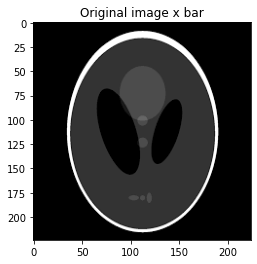

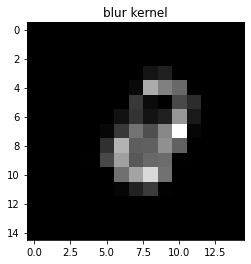

Test adjointness of operator
x shape:  (224, 224)
y shape:  (224, 224)
Phi(x) shape:  (224, 224)
Phit(y) shape:  (224, 224)
forward:  12587.849927249492
backward:  12587.84992724949
-----------------------------
Norm squared of the direct operator:  0.99865056770323


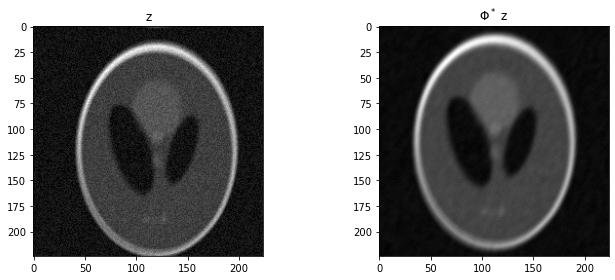

In [3]:
# load image (RGB and convert to grayscale)
#im = Image.open('images/bears.jpg').convert('L')
im = Image.open('images/shepp_logan_phantom.png').convert('L')
#im = Image.open('images/cameraman.png').convert('L')
xtrue = np.array(im) 
#xtrue = xtrue / xtrue.max()

print("Display original image size:")
print(xtrue.shape)
# convert to even size
if xtrue.shape[0]%2 == 1:
    xtrue = xtrue[:-1,...]
if xtrue.shape[1]%2 == 1:
    xtrue = xtrue[...,:-1]
nx, ny = xtrue.shape

imshowgray(xtrue, 'Original image x bar')

# load blur kernel
pth_kernel='blur_models/blur_3.mat'
h = scipy.io.loadmat(pth_kernel)
h = np.array(h['blur'])
imshowgray(h, 'blur kernel')

# define operators
Phi, Phit = get_operators(type_op='deconvolution', pth_kernel=pth_kernel)

# test adjoint
test_adj = True
if test_adj is True:
    print('Test adjointness of operator')
    xtmp = np.random.rand(*xtrue.shape)
    Phixtmp = Phi(xtmp)
    ytmp = np.random.rand(*Phixtmp.shape)
    Phitytmp = Phit(ytmp)
    print('x shape: ', xtmp.shape)
    print('y shape: ', ytmp.shape)
    print('Phi(x) shape: ', Phixtmp.shape)
    print('Phit(y) shape: ', Phitytmp.shape)
    fwd = np.sum(xtmp.flatten()*Phitytmp.flatten())
    bwd = np.sum(Phixtmp.flatten()*ytmp.flatten())
    print('forward: ', fwd)
    print('backward: ', bwd)
    print('-----------------------------')
   

# power method to compute spectral norm of Phi
normPhi2 = op_norm2(Phi, Phit, xtrue.shape)
print('Norm squared of the direct operator: ', normPhi2)


# degraded data
x_blurred = Phi(xtrue)
nxb, nyb = x_blurred.shape
std = 40
z = x_blurred+std*np.random.rand(nxb,nyb) 
#ntheta = nx #uncomment for tomography
xrec =  Phit(z)

xrec = xrec.reshape(nx, ny)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(z.reshape(nxb, nyb), cmap="gray")
axs[0].set_title("z")

axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")

fig.tight_layout()


## 2- Wavelet based reconstruction with FB and FISTA


PDF FB: https://www.ljll.math.upmc.fr/~plc/mms1.pdf

PDF FISTA (Chambolle-Dossal): https://hal.inria.fr/hal-01060130v3/document

PDF FISTA (Beck-Teboulle): http://kissen.cs.uni-dortmund.de:8080/LEHRE/VORLESUNGEN/LOPT/SS16/papers/FISTA.pdf

### 2.1- FB
Assume that $f,h$ are $\Gamma_0(\mathcal{H})$ and $h$ is differentiable with a $\beta$-Lipschitz gradient. Forward-Backward and FISTA algorithms aim to solve:
$$
\widehat{x} \in \textrm{Argmin}_x h(x) +  f(x)
$$



Let $\gamma \in ]0,2/\beta[$, the forward-backard iterations reads:
$$
(\forall k \in \mathbb{N}) \qquad 
x_{k+1}=\operatorname{prox}_{\gamma f}\left(x_{k} - \gamma h(x_k)\right) \\
$$
The sequence $(x_k)_{k \in \mathbb{N}}$ converges to a minimizer of $h + g$.

For this context of image reconstruction we focus on sparse penalization after a wavelet transform considering the optimization problem:

$$\hat{\mathrm{x}}_{\lambda}\in\underset{\mathrm{x}\in \mathbb{R}^N}{\text{Argmin}} \frac{1}{2}\Vert \Phi \mathrm{x} -\mathrm{z} \Vert^2_2 + \lambda\Vert \Psi \mathrm{x}\Vert_1$$



In [4]:
def prox_L1(x, tau):
    return np.sign(x)*np.maximum(np.abs(x)-tau,0)

In [5]:
wave_choice = 'db8'
Psi,Psit = wavelet_op(Phit(z), wav=wave_choice, level=3, test_ajd=True)
print('Reconstruction using ', wave_choice, ' WT')


-----------------------------
Test wavelet
forward:  1556.0545528904613
backward:  1556.054552890461
-----------------------------
Reconstruction using  db8  WT


In [6]:
normPhi2 = op_norm2(Phi, Phit, xrec.shape)
gamma    = 1.99/normPhi2
normPsi2 = op_norm2(Psi, Psit, xrec.shape)

lam    = 5; # regularisation parameter
niter  = 500



x_n = 0*Phit(z)

table_energy = 1e10*np.ones(niter)
table_PSNR = 1e10*np.ones(niter)
    
for k in range(0,niter):
    g_n = Phit((Phi(x_n) - z))
    tmp = prox_L1(Psi(x_n-gamma*g_n),gamma*lam)
    x_n = Psit(tmp)
    table_energy[k] = 0.5*np.sum((Phi(x_n) - z)**2)+lam*np.sum(np.abs(tmp)) 

xrec_fb = x_n  
energy_fb = table_energy 


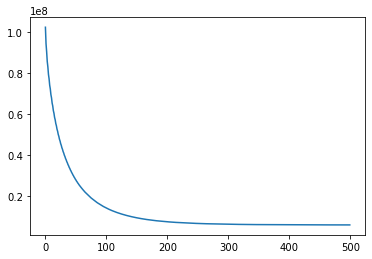

In [7]:
plt.plot(energy_fb)

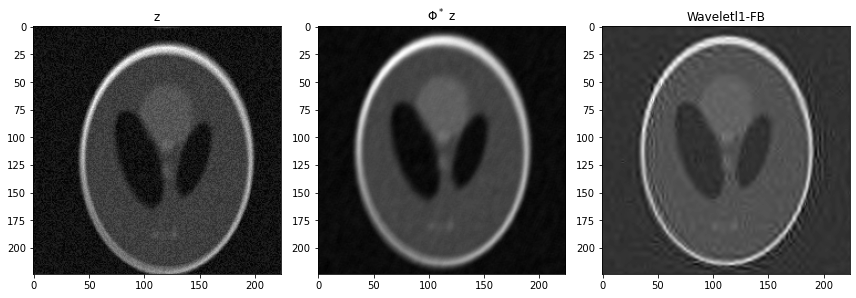

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#axs[0].imshow(z.reshape(ntheta, ny), cmap="gray") #tomography
axs[0].imshow(z.reshape(nx, ny), cmap="gray") #deconvolution
axs[0].set_title("z")

axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")

axs[2].imshow(xrec_fb, cmap="gray")
axs[2].set_title("Waveletl1-FB")

fig.tight_layout()

### 2.2- FISTA
Assume that $f,h$ are $\Gamma_0(\mathcal{H})$ and $h$ is differentiable with a $\beta$-Lipschitz gradient. Forward-Backward and FISTA algorithms aim to solve:
$$
\widehat{x} \in \textrm{Argmin}_x h(x) +  f(x)
$$



Let $\gamma \in ]0,2/\beta[$, the forward-backard iterations reads:
\begin{align}
(\forall k \in \mathbb{N}) \qquad 
x_{k}&=\operatorname{prox}_{\gamma f}\left(v_{k-1} - \gamma h(v_{k-1})\right) \\
t_k& = \frac{k+a-1}{a}\\
\alpha_k &= \frac{t_k - 1}{t_{k+1}}\\
v_{k} &= x_{k} + \alpha_k*(x_{k} - x_{k-1})
\end{align}
The sequence $(x_k)_{k \in \mathbb{N}}$ converges to a minimizer of $h + g$.

For this context of image reconstruction we focus on sparse penalization considering the optimization problem:

$$\hat{\mathrm{x}}_{\lambda}=\underset{\mathrm{x}\in \mathbb{R}^N}{\text{argmin}} \frac{1}{2}\Vert \Phi \mathrm{x} -\mathrm{z} \Vert^2_2 + \lambda\Vert \Psi \mathrm{x}\Vert_1$$



In [9]:
normPhi2 = op_norm2(Phi, Phit, xrec.shape)
gamma    = 0.99/normPhi2
normPsi2 = op_norm2(Psi, Psit, xrec.shape)
a        = 4



v_k = 0*Phit(z)
x_k = v_k
table_energy = 1e10*np.ones(niter)
table_PSNR = 1e10*np.ones(niter)
t_k = 0

for k in range(0,niter):
    x_k0 = x_k
    g_k = Phit((Phi(v_k) - z))
    tmp = prox_L1(Psi(v_k-gamma*g_k),gamma*lam)
    x_k = Psit(tmp)
    t_k0 = t_k
    t_k = (k+a)/a
    alpha_k = (t_k0 - 1)/t_k
    v_k = x_k + alpha_k*(x_k - x_k0)
    
    table_energy[k] = 0.5*np.sum((Phi(v_k) - z)**2)+lam*np.sum(np.abs(Psi(v_k))) 

    
xrec_fista = x_k  
energy_fista = table_energy  

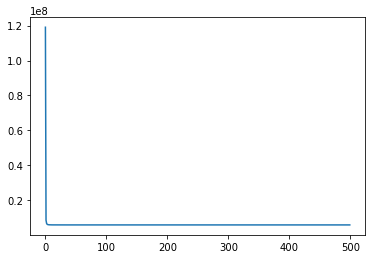

In [10]:
plt.plot(energy_fista)

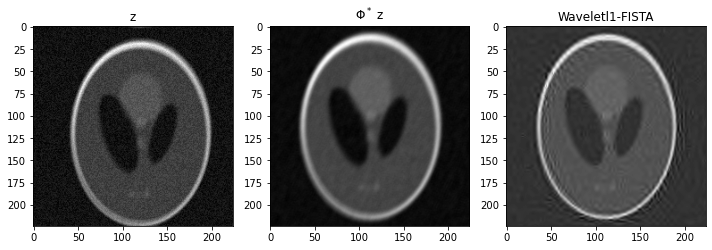

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
#axs[0].imshow(z.reshape(ntheta, ny), cmap="gray") #tomography
axs[0].imshow(z.reshape(nx, ny), cmap="gray") #deconvolution
axs[0].set_title("z")

axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")

axs[2].imshow(xrec_fista, cmap="gray")
axs[2].set_title("Waveletl1-FISTA")

fig.tight_layout()

### Comparison between FB and FISTA

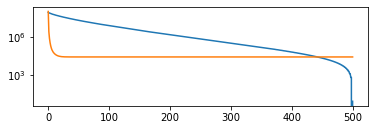

In [12]:
minfb = np.amin(energy_fb)
minfista = np.amin(energy_fista)
minval = np.minimum(minfb, minfista)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(energy_fb-minval)
line, = ax.plot(energy_fista-minval)
ax.set_yscale('log')

plt.show()

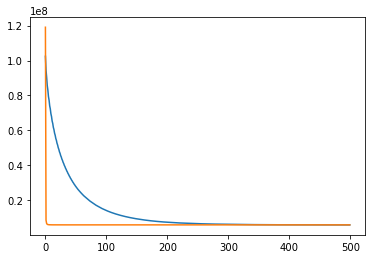

In [13]:
plt.figure();
plt.plot(energy_fb)
plt.plot(energy_fista)
plt.show()

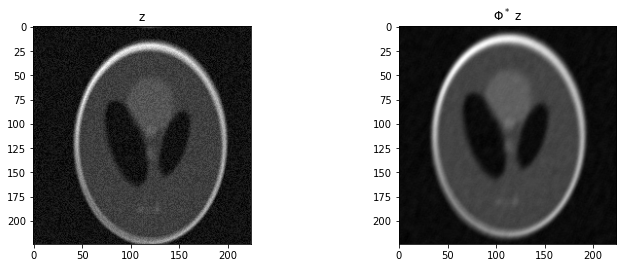

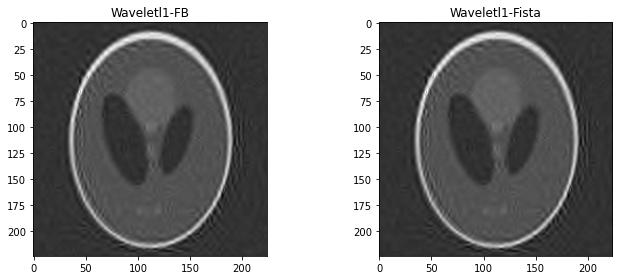

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#axs[0].imshow(z.reshape(ntheta, ny), cmap="gray") #tomography
axs[0].imshow(z.reshape(nx, ny), cmap="gray") #deconvolution
axs[0].set_title("z")

axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(xrec_fb, cmap="gray")
axs[0].set_title("Waveletl1-FB")


axs[1].imshow(xrec_fista, cmap="gray")
axs[1].set_title("Waveletl1-Fista")

fig.tight_layout()

## 3- TV reconstruction with Condat-Vu algorithm

PDF : https://hal.archives-ouvertes.fr/file/index/docid/722823/filename/Condat-splitting.pdf


Condat-Vu algorithm algorithm to solve:
$$
\min_x f(x) + h(x) + g(Lx)
$$
when $f,h$ are $\Gamma_0(\mathcal{H})$ and $h$ is differentiable with a $\beta$-Lipschitz gradient, $L$ is a bounded linear operator from $\mathcal{H}$ to $\mathcal{G}$ and $g$ is in $\Gamma_0(\mathcal{G})$. 

Let $\tau \in ]0,+\infty]$, $\sigma\in]0,+\infty]$ and $\frac{1}{\tau} - \sigma\Vert L\Vert^2\geq \frac{\beta}{2}$


    
$$
(\forall n \in \mathbb{N}) \quad\left\{\begin{array}{l}
x_{n+1}=\operatorname{prox}_{\tau f}\left(x_{n} - \tau h(x_n) - \tau L^{*} v_{n}\right) \\
y_{n}=2 x_{n+1}-x_{n} \\
v_{n+1}=\operatorname{prox}_{\sigma g^{*}}\left(v_{n}+\sigma L y_{n}\right)
\end{array}\right.
$$

For this context of image reconstruction we focus on sparse penalization considering the optimization problem:

$$\hat{\mathrm{x}}_{\lambda}=\underset{\mathrm{x}\in \mathbb{R}^N}{\text{argmin}} \frac{1}{2}\Vert \Phi \mathrm{x} -\mathrm{z} \Vert^2_2 + \lambda\Vert \mathrm{D} \mathrm{x}\Vert_1$$

### 3.1 - Total variation reconstruction

$\Psi$ and $\Psi^\top$ denote the horizontal/vertical finite difference operator and its adjoint

In [15]:
Psi, Psit = tv_op(Phit(z), test_ajd=True)
print('Reconstruction using TV')
normPsi2 = op_norm2(Psi, Psit, xrec.shape)
print(normPsi2)

-----------------------------
Test wavelet
forward:  -46.933115657411044
backward:  -46.93311565741101
-----------------------------
Reconstruction using TV
7.980594707804998


In [16]:
def ProjGradBouleInf(x,l,tau):
    temp = x - tau*prox_L1(x/tau, l/tau)
    return temp



In [17]:
# TV
lam  = 2.5;

beta   = op_norm2(Phi, Phit, xrec.shape)
normL2 = normPsi2
sig    = 1
tau    = 0.99/(beta/2 + sig*normL2)
x0     = xrec

x_n = Phit(z)
v_n = Psi(x_n)

table_energy = 1e10*np.ones(niter)
    
for k in range(0,niter):
    g_n = Phit((Phi(x_n) - z))

    x_n1 = x_n-tau*g_n-tau*Psit(v_n)
    y_n = 2*x_n1-x_n
    v_n = ProjGradBouleInf(v_n+sig*Psi(y_n),lam,sig)
 
    table_energy[k] = 0.5*np.sum((Phi(x_n) - z)**2)+lam*np.sum(np.abs(Psi(x_n)))
    
    x_n= x_n1
   
    
xrec_cv_tv = x_n  
energy_cv_tv = table_energy



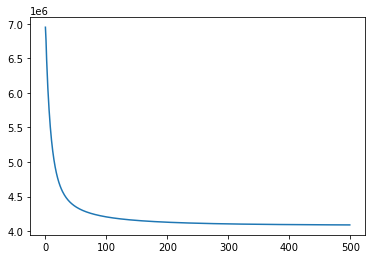

In [18]:
plt.plot(energy_cv_tv)

### Comparison between $\ell_1$-wavelet and TV regularisations

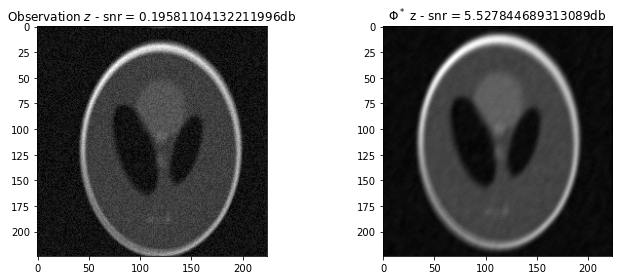

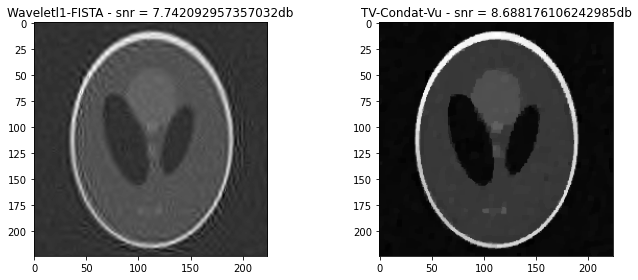

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(z.reshape(nx, ny), cmap="gray")
axs[0].set_title("Observation $z$ - snr = " + str(snr_numpy(xtrue,z.reshape(nx, ny)))+"db")
axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z - snr = " + str(snr_numpy(xtrue,xrec))+"db")
fig.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(xrec_fista, cmap="gray")
axs[0].set_title("Waveletl1-FISTA - snr = " + str(snr_numpy(xtrue,xrec_fista))+"db")
axs[1].imshow(xrec_cv_tv, cmap="gray")
axs[1].set_title("TV-Condat-Vu - snr = " + str(snr_numpy(xtrue,xrec_cv_tv))+"db")
fig.tight_layout()

